# ENTRENAR LA RED

Una vez tienes tu diseño de red y los datos, ya podemos entrenar la red. Esto no se hace desde un Jupyter notebook, pero aquí te voy a dejar explicado como lo tienes que hacer (igualmente quedamos y te enseño a hacerlo, pero esto te queda para que luego consultes)

Vas a tener que abrir distintos archivos de texto, editarlos y guardarlos, por tanto ten en cuenta que:
* ABRIR: `emacs nombre_fichero`
* EDITAR: escribes y borras lo que quieras
* GUARDAR: `ctrl+c`, `ctrl+s`
* CERRAR: `ctrl+c`, `ctrl+x`

En tu `HOME` del CESGA vas a encontrar una carpeta que se llama `tfg_xan`. Ahí se encuentran los archivos necesarios para poder correr la red neuronal. Vas a encontrar:

* `NEXT_graphs`: archivos .py con las funciones de entreno, las arquitecturas de red...
    * `networks`: archivo donde pegar las redes que tú hayas creado (`architectures.py`) --> **al abrir el archivo encontrarás una red de prueba; puedes dejarla o borrarla y pegar ahí tus otras redes**
    * `utils`: diferentes archivos de python con funciones para distintas funciones (leer los datos, entrenar la red...) --> **de estos archivos en principio sólo tienes que entrar en `data_loader.py` y añadir en `LabelType` el nombre de tu red/redes tal y como esá hecho con la red de prueba**
* `notebooks`: ahora mismo no tiene nada pero puedes usarla para poner ahi tus notebooks en lugar de tenerlos en `HOME`
* `scripts`: tiene un script que se llama `main.py`. Este script tiene 2 funcionalidades: entrenar la red (cargar los datos, construir la red, tomar las funciones de entreno que están en `train_utils.py` y pasar nuestros datos por ellas para entrenar la red); y también predecir los datos con la red (cargar los datos, tomar la red entrenada y pasar los datos de test por ella para ver los resultados). Este es el corazón del proceso, pero **no tendrás que tocarlo directamente**.

* `templates`: FINALMENTE esto contiene lo más importante y lo que tendrás que manejar cada vez que vayas a entrenar, que son los **ficheros de configuración y los scripts .sh**



## SCRIPTS

Necesitas 3 cosas para poner en marcha un entreno/predicción:

* **`CONFIG`**: fichero con todas las **VARIABLES** necesarias para el entreno. Contiene todo: el nombre del fichero de datos, el nombre de la red, los parámetros de la red, el tipo de entreno, número de epochs que quieres que entrene, tamaño del batch, las carpetas en las que guardar toda la info... todo lo que te puedas imaginar.

* **`TASK`**: fichero donde escribes la **ACCIÓN** que quieres realizar, es decir, el comando. En nuestro caso es una sóla línea para correr el script `main.py` del que hablé antes, en la cual llamas con python a ese script, le dices qué acción tiene que hacer con `-a` y le indicas que archivo de config coger con `-conf`, por ejemplo: `python /path/to/main.py -a train -conf /path/to/conf/file.conf`

* **`JOB`**: fichero en el que das la **ORDEN** de correr una task al CESGA, con ciertas especificaciones, tales como el numero de tasks a correr (`--ntasks`, que en este caso es 1 ya que por cada job mandas sólo 1 entreno), el tiempo que quieres que te den para correr tu script (`--time`, que en principio lo dejamos a 6 horas, ya que poner más hace que tarde más tiempo en que empiece a correr), la memoria que necesitas por cpu (`--mem-per-cpu`, esto hay que adaptarlo, te explico más abajo), el numero de cores (`--cpus-per-task`, en nuestro caso, van a ser 32 siempre)... y finalmente la orden, que es la línea al final donde pone `srun --ntasks 1 --exclusive --cpus-per-task N /path/to/task.sh`. 

Como ves, una encadena a otra: el `job` manda a correr una `task`, y la `task` manda correr al script `main.py` con un `config` que tu le das. Lo único que hay que hacer es poner en estos archivos lo que quieres hacer, y luego correr el job.

Para entrenar necesitas 3 (`train_net.conf`, `train_task.sh`, `train_job.sh`), y para predecir también 3 (`pred_net.conf`, `pred_task.sh`, `pred_job.sh`), por eso en la carpeta templates hay 6 ficheros para que tengas como referencia.

## Guía para los jobs

En el `job` es importante que  sepas que usamos una GPU (es mucho más rápida que las máquinas normales), y por requerimientos del CESGA tenemos que pedir siempre 32 cores como dije arriba. Entonces, para controlar la memoria que pedimos en cada job, ese número queda fijo y variamos el valor de `--mem-per-cpu`. Si pedimos 1G de memoria por cpu, entonces tendremos 1G * 32 cores = 32 G. 

Para entrenar una red vamos a necesitar tener como MÍNIMO tanta memoria como ocupan nuestros datos (para 13 bar los datos ocupan 4.1G, para 5 bar, 12G...) más lo que ocupe la red en sí, etc. Te dejo como recomendación por lo que ya probé yo, los valores que vas a necesitar para cada presión:

* **`13bar`**: con ~15G en total es suficiente, puedes poner `500M`  por cada cpu.
* **`5bar`** : con ~30G en total es suficiente, puedes poner `1G`    por cada cpu.
* **`2bar`** : con ~45G en total es suficiente, puedes poner `1500M` por cada cpu.
* **`1bar`** : con ~80G en total es suficiente, puedes poner `2500M` por cada cpu.

De todas formas esto depende de varias cosas, si mandas un job y se cancela por falta de memoria, tendrás que subir un poco los valores que te estoy dando ya que son una aproximación.

Luego, el tema del tiempo, tenes 3 posibilidades:

* Hasta 6 horas: el job tiene prioridad máxima, empieza a correr muy rápido.
* Entre 6 horas y 3 días: el job tiene menos prioridad, tarda en empezar más tiempo, a veces días.
* Más de 3 días: aun menos prioridad, nunca probé pero debe tardar mucho en empezar.

En principio, con 6 horas en la mayoría vamos bien, quizás los de 2 y 1 bar que tardan más podemos poner más horas, y aunque tarden mucho en empezar no tienes que estar pendiente, eso vamos mirando. También hay la posibilidad de mandar siempre 6 horas, y si el entreno se quedó muy corto, reanudar durante otras 6 horas donde nos quedamos (esta opción simplemente requiere estar más atento continuamente, entrar y ver si acabaron, cambiar los scripts para relanzarlos...)

## Cómo hacerlo

Yo te recomiendo que cada vez que quieras entrenar (y posteriormente predecir) una red, sigas los siguientes pasos:

* Crea una carpeta para el entrenamiento dentro de la carpeta de la presión en `LUSTRE` (el comando es `mkidr nombre_carpeta`)
* Dale un nombre que te identifique el entreno. Ahora mismo hay un ejemplo dentro de la carpeta de `13bar` que se llama `test_train`, para que tengas de referencia.
* En tu carpeta creada vas a crear 3 carpetas: `checkpoints`, `logs`, `scripts`.
* En `checkpoints` se irán guardando automáticamente "capturas" de tu red durante el entreno, para poder luego cargarla y usarla con las variables de ese instante.
* En `logs` se van guardando la información del entreno.
* En `scripts` lo que vas a hacer es copiar los 6 ficheros de la carpeta `templates` (haces `scp ficheros_a_copiar carpeta_destino`, si usas `*` te copia todos los ficheros de una carpeta)
* Una vez los tienes copiados, cambia todo lo necesario (lo principal es que cambies los paths que hay, para que el job sepa qué task correr, y esta qué config usar, y dentro del config igual, tomar los distintos paths para que se lean los datos adecuados, etc). Este es el paso importante, ya que un fallo aquí o que te olvides de cambiar algo puede llevar a la confusión, o a que no funcione la red. También es importante que las especificaciones del job las cambies (más tiempo, más memoria para que no se rompa el job...)
* Para editar esos archivos de texto, los puedes abrir con `emacs nombre_fichero` y ahi editar; para guardar haces `Ctrl+c, Ctrl+s` y para cerrar hacer `Ctrl+c, Ctrl+x`
* Cuando estés completamente seguro de que tienes todo a punto, puedes mandar el job haciendo `sbatch train_job.sh``
* Puedes comprobar el estado de tu job haciendo `squeue`, ver cuánto tiempo lleva corriendo...

También es importante que veas los ficheros de log y de error que crea. Deberían estar en la carpeta `logs` que creaste. Ahí te informa si hay algún error durante el job, para así poder solucionarlo. Tienes que comprobar siempre estos ficheros a ver qué te dicen (puedes hacer print de ellos haciendo `cat nombre_fichero`)

## TENSORBOARD: monitorizar el entreno

Hay un archivo que se guarda automáticamente en la carpeta `logs` con la información del entreno para poder ver qué pasa.

In [1]:
import sys
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

home_path = ! echo $HOME
lustre_path = ! echo $LUSTRE

sys.path.append(home_path[0] + '/tfg_xan')

from NEXT_graphs.utils.read_tensorboard import load_tensorboard_df

Con el entreno de prueba que hize (con la red de prueba) podemos ver un ejemplo de este fichero:

In [2]:
path_tb = '/data/13bar/test_train/logs/'
file_tb = 'events.out.tfevents.1714747781.c202-8.2520132.0'


tb_test = load_tensorboard_df(lustre_path[0] + path_tb + file_tb)

Vemos que tiene el tiempo (tiempo de reloj del ordenador) de cada `epoch` (se llama `step` aquí), la `loss` para los datos de entreno y validación, la `accuracy` también y el `learning rate`,  que es un parámetro del entreno que hicimos que fuera cambiando (nos interesa ver cómo cambia)

In [3]:
tb_test

,wall_time,step,loss_train,loss_valid,acc_train,acc_valid,lr
0,1.714748e+09,0,0.691884,0.687764,0.518975,0.535923,0.0005
1,1.714748e+09,1,0.672187,0.647201,0.613023,0.687354,0.0005
2,1.714748e+09,2,0.622727,0.602177,0.690759,0.677035,0.0005
3,1.714748e+09,3,0.585331,0.574097,0.706676,0.701859,0.0005
4,1.714748e+09,4,0.569484,0.569967,0.710178,0.721184,0.0005
5,1.714749e+09,5,0.565230,0.566720,0.712494,0.721135,0.0005
6,1.714749e+09,6,0.564225,0.571334,0.712093,0.691637,0.0005
7,1.714749e+09,7,0.562565,0.568030,0.714257,0.720940,0.0005
8,1.714749e+09,8,0.563717,0.565562,0.712573,0.699718,0.0005
9,1.714749e+09,9,0.562900,0.561690,0.714044,0.713298,0.0005


Lo que deberías hacer por cada entreno son gráficas de epoch vs loss y epoch vs accuracy, comparando el entreno y la validación. Te había comentado que los datos de validación sirven para ver que la red no está haciendo cosas raras, aquí podrás verlo.

También de aquí puedes sacar el tiempo medio que te tarda cada epoch, que es interesante, y ver cómo varía el learning rate (lo puedes superponer a las gráficas de epoch vs loss/acc, poniendo los valores del eje Y de ambos, uno a la izq y otro a la derecha, ya que van a estar en escalas distintas)

## PREDECIR: tras el entreno, miramos los resultados

Una vez entrenas la red, la prueba final es ver qué tal funciona con datos diferentes que nunca ha visto la red. Durante el entreno, en la carpeta `checkpoints` se han ido guardando "capturas" de la red, con los valores de las variables que la red tenía en un cierto epoch. Sólo se guardan esas capturas si la loss de la validación ha bajado respecto a epochs anteriores, así que no guardamos todos. 

Lo habitual entonces es tomar el último checkpoint guardado, ya que sería el de mejor resultado. No siempre es así, tenemos que mirar antes el tensorboard y comprobar que no sucedan cosas raras (imagínate que mandamos 200 epoch, pero a partir del epoch 100 vemos que el comportamiento no es bueno, no deberíamos tomar esos checkpoints aunque coincida que alguno es bueno, ya que se ve que el entrenamiento es inestable, y cogeríamos uno de antes del epoch 100).

En el entreno de prueba que hice en la carpeta `test_train` podemos ver que hay varios checkpoints guardados. Lo que hay que hacer ahora es mandar un job de predicción, con los 3 scripts de predicción que te dije antes. Es importante que en el `config` escojas el checkpoint que va a cargar la red! En este caso, yo escogí el checkpoint 19 ya que era el último. En el `config` también tienes que escoger el fichero de datos, y el nombre y path del fichero con la predicción, es decir, con la salida de la red. Luego la `task` es igual que para el entreno, pero cambiando la acción `-a` y el `config`, y el job lo mismo, cambia la task a la de predicción. Además, como sólo van a pasar los datos de test 1 vez, no hace falta darle mucho tiempo (deja las 6 horas).

Una vez mandas el job, y este termina, tenemos el fichero de predicción del que sacaremos resultados:

In [4]:
pred_path = '/data/13bar/test_train/pred_test.h5'
pred_test = pd.read_hdf(lustre_path[0] + pred_path, 'EventPred')

Tenemos el el fichero el `file_id` y el `dataset_id` por si quisiéramos ver cómo son los eventos originalmente, tenemos su `binclass`, que nos dice si es señal (1) o fondo (0), y tenemos al probabilidad de que el evento sea de fondo (`class_0`) o de que sea de señal (`class_1`). 

Con estos datos podemos sacar la accuracy (el % de veces que la red acertó, tomando que si una clase tiene más del 50% de posibilidades, esa es la escogida) y la curva ROC, que nos da una información más concreta de cuál sería el threshold óptimo para considerar que un evento es señal o no (es decir, va comprobando distintos números de porcentaje y cómo esto influye en el resultado; puede ser que el threshold óptimo sea considerar que son señal los eventos que tengan un % mayor del 35%, en lugar del 50%)

In [5]:
pred_test

,file_id,dataset_id,binclass,class_0,class_1
11,1,14,0,0.201972,0.798028
3,1,17,1,0.187322,0.812678
9,1,18,1,0.543716,0.456284
26,1,19,1,0.215049,0.784951
15,1,27,1,0.781285,0.218716
...,...,...,...,...,...
11,2000,0,0,0.467321,0.532679
28,2000,9,0,0.807377,0.192623
5,2000,18,0,0.682498,0.317502
26,2000,36,0,0.682401,0.317599


In [45]:
from sklearn.metrics import roc_curve, auc

La curva ROC se construye a partir del concepto de Confusion Matrix, que es la matriz 2x2 que nos dice el número de eventos de señal que predecimos como señal (True Positives, TP), el número de eventos de fondo que predecimos como fondo (True Negative, TN), el número de eventos de señal que predecimos como fondo (False Negative, FN), y el número de eventos de fondo que predecimos como señal (False Positive, FP). 

Con estos 4 números obtenemos la 
* True Positive Rate:  TP / (TP + FN) = TP / N_signal
* False Positive Rate: FN / (TP + FN) = FN / N_signal

* True Negative Rate:  TN / (FP + TN) = TN / N_background
* False Positive Rate: FP / (FP + TN) = FP / N_background

En la curva ROC representaremos el TNR vs TPR

Un ejemplo de cómo sería la curva. El área bajo la curva (AUC, area under curve) nos da una estimación también de lo bueno que es nuestro modelo, cuando mayor es este valor, mejor es nuestro modelo (siendo 1 el máximo):

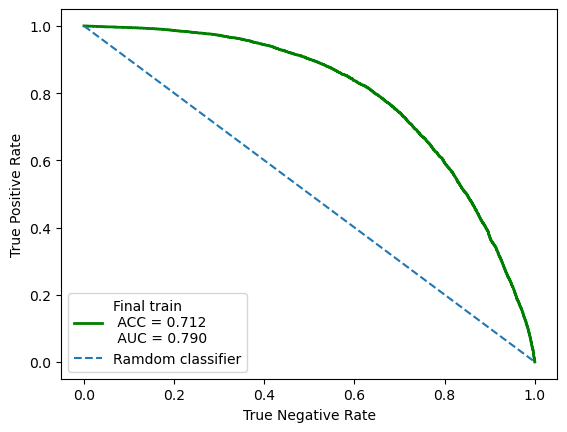

In [115]:
y_true = pred_test.binclass
y_pred = pred_test.class_1
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

regular_acc = sum((pred_test['class_1'] > 0.5).astype(int) == pred_test.binclass.values) / len(pred_test)

plt.plot(1-fpr, tpr, 'g', lw = 2, label = 'Final train\n ACC = {:.3f}\n AUC = {:.3f}'.format(regular_acc, roc_auc))
plt.plot([0, 1], [1, 0], '--', label = 'Ramdom classifier')
plt.legend()
plt.xlabel('True Negative Rate')
plt.ylabel('True Positive Rate')
plt.show()

Las curvas ROC que estén por encima de la línea descontinua son mejores que un clasificador aleateorio, por tanto nuestra red está aprendiendo. 

Del resultado que sale de la función `roc_curves` podemos encontrar el threshold que mejor se adapta a nuestra red, y hay distintas métricas para encontrarlo. 

Por ejemplo, si quisiéramos tener el threshold para obtener el mayor número de aciertos tanto de señal como de fondo, tendríamos que buscar el punto que está más hacia la esquina superior derecha:

In [116]:
best_position = np.argmax(tpr - fpr)
best_threshold = thresholds[best_position]
print("Best Threshold:", best_threshold)

Best Threshold: 0.43059608


Es decir, ese threshold debería darnos una mejor accuracy que el de 0.5 que fijamos inicialmente:

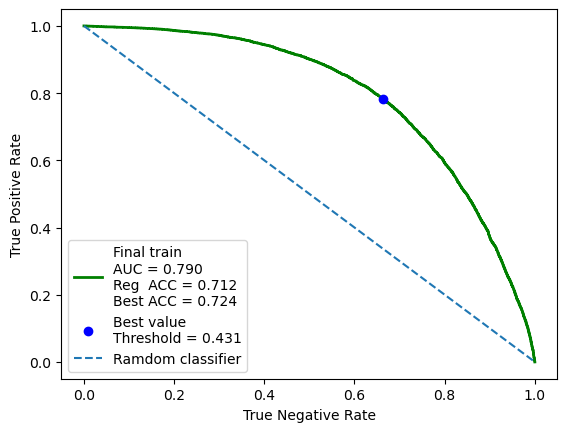

In [138]:
#accuracy con mas del 50%
regular_acc = sum((pred_test['class_1'] > 0.5).astype(int) == pred_test.binclass.values) / len(pred_test)

#accuracy con el mejor threshold
best_acc    = sum((pred_test['class_1'] > best_threshold).astype(int) == pred_test.binclass) / len(pred_test)

plt.plot(1-fpr, tpr, 'g', lw = 2, label = 'Final train\nAUC = {:.3f}\nReg  ACC = {:.3f}\nBest ACC = {:.3f}'.format(roc_auc, regular_acc, best_acc))
plt.plot(1 - fpr[best_position], tpr[best_position], 'ob', label='Best value\nThreshold = {:.3f}'.format(best_threshold))
plt.plot([0, 1], [1, 0], '--', label = 'Ramdom classifier')
plt.legend()
plt.xlabel('True Negative Rate')
plt.ylabel('True Positive Rate')
plt.show()

Pero nosotros no buscamos que acierte lo mejor posible todo... buscamos que el número de veces que acierta que un evento de señal es señal sea máximo (es decir, maximizar el TP), y que el número de veces que confunde un evento de fondo como señal sea mínimo (el FP): es decir, reducir los falsos positivos y aumentar los verdaderos positivos. Para eso definimos la figure of merit (FoM) como:

$fom = \frac{TPR}{\sqrt{FPR}}$

Podemos entonces construir la figura, y el mejor threshold será dónde la FoM sea máxima

Best FOM Threshold: 0.464649


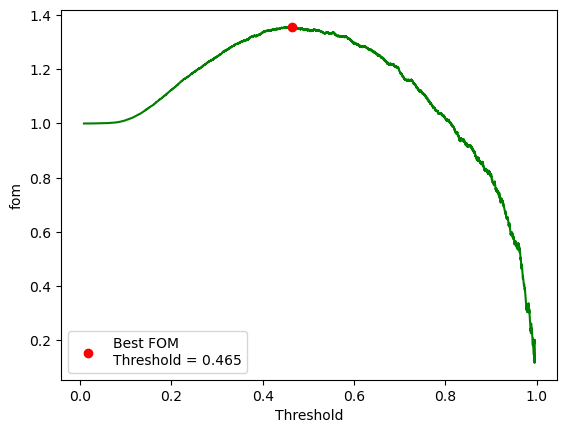

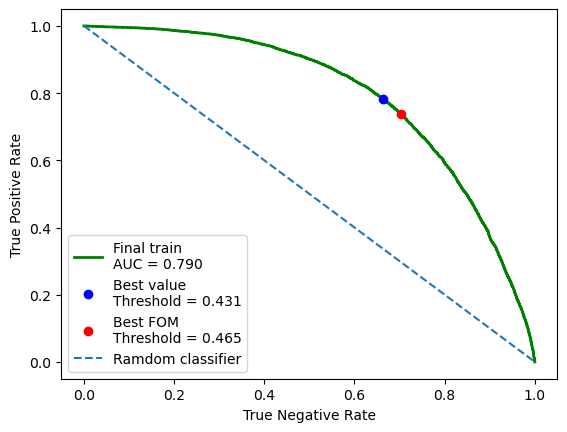

In [141]:
#Quito los 0 de FPR para evitar conflictos
nonzero = ~(fpr == 0)
nonzero_tpr = tpr[nonzero]
nonzero_fpr = fpr[nonzero]
nonzero_thr = thresholds[nonzero]

#Calculo FOM
fom = nonzero_tpr/np.sqrt(nonzero_fpr)

#Busco el máximo
best_fom_pos = np.argmax(fom)
best_fom_thr = nonzero_thr[best_fom_pos]
print("Best FOM Threshold:", best_fom_thr)

plt.plot(nonzero_thr, fom, 'g-')
plt.plot(best_fom_thr, fom[best_fom_pos], 'ro', label='Best FOM\nThreshold = {:.3f}'.format(best_fom_thr))
plt.legend()
plt.xlabel('Threshold')
plt.ylabel('fom')
plt.show()


plt.plot(1-fpr, tpr, 'g', lw = 2, label = 'Final train\nAUC = {:.3f}'.format(roc_auc))
plt.plot(1 - fpr[best_position], tpr[best_position], 'ob', label='Best value\nThreshold = {:.3f}'.format(best_threshold))
plt.plot(1 - fpr[best_fom_pos], tpr[best_fom_pos],   'or', label='Best FOM\nThreshold = {:.3f}'.format(best_fom_thr))
plt.plot([0, 1], [1, 0], '--', label = 'Ramdom classifier')
plt.legend()
plt.xlabel('True Negative Rate')
plt.ylabel('True Positive Rate')
plt.show()

Vuelvo a plotear la ROC para que veas que son puntos algo distintos.

## TAREAS

Con esto ya estaría todo. Lo que tienes que hacer es este proceso para las 4 presiones (es decir, entrenar, monitorizar el entreno, predecir y mirar resultados), y la idea es hacerlo como hablamos con una red sencilla como la que construimos el otro día y con una red más compleja (compleja a nivel de cálculos internos, a nivel de tarea tuya no es mucho más complejo). Así podemos comparar resultados a distintas presiones, y resultados entre las redes.